In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
def ransac(src_data, p=0.99, ratio=0.5, model='line', inlier_thre=3.84, rseed=19): 
    #自定义ransac函数，src_data.shape = (N,2), p为迭代times后至少有一次选取的minset都为内点的概率，ratio为内点概率
    #model为模型选择，inlier_thre为判定是否为内点阈值，rseed为随机数种子
    model_dict = {'line':2, '3Dplane':3} #表示模型需要多少个点
    data = np.array(src_data, dtype=np.float32) #导入数据
    minset = np.zeros((model_dict[model], data.shape[1]), dtype=np.float32) #设置最小采样
    times = int((np.log(1-p)/np.log(1-pow((1-ratio), model_dict[model])))) #计算迭代次数
    param = np.zeros((times, data.shape[1]), dtype=np.float32) #设置所有迭代计算的模型参数
    inliers = np.zeros((times), dtype=np.int32) #设置模型在所有参数下内点个数
    for i in range(times): #迭代times次
        np.random.seed(rseed + i * 10) #设置随机数种子
        np.random.shuffle(data) #每次迭代打乱data的顺序
        minset = data[:minset.shape[0], :minset.shape[1]] #取data的前 minset.shape[0] 行，前 minset.shape[1] 列作为本次迭代的 minset
        if minset[1,0] - minset[0,0] < 1e-8: #斜率不存在的情况
            inliers[i] = (abs(src_data[:,0]-minset[0,0])<inlier_thre).sum()
            continue
        param[i,0] = (minset[1,1] - minset[0,1]) / (minset[1,0] - minset[0,0]) #计算两点斜率
        param[i,1] =  minset[0,1] - param[i,0] * minset[0,0] #计算偏置 
        inliers[i] = (abs(src_data[:,0] * param[i,0] + param[i,1] - src_data[:,1]) / np.sqrt(param[i,0] ** 2 + 1) < inlier_thre).sum()
        #计算在此参数下所有点的距离并count大于阈值的点，结果保存在 inliers 里，保证 param 和 inliers 对应索引相同
    return param, inliers #函数返回所有的模型参数和对应内点个数

(100,) (100,) [[3.0000002 3.9999962]
 [3.        4.       ]
 [2.9999998 4.000001 ]
 [2.9999998 4.000002 ]]


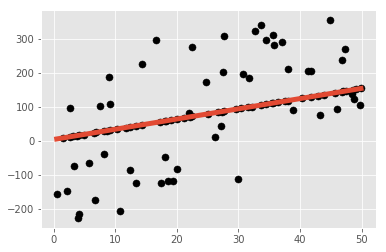

In [3]:
#绘图验证函数1
rng = np.random.RandomState(19)
X = np.sort(50 * rng.rand(100, 1), axis=0).ravel()
Y = 3 * X + 4
Y[::2] += 500 * (0.5 - rng.rand(50))
test_data = np.array((X,Y)).T
param, inliers = ransac(test_data)
params = param[np.where(inliers==inliers.max())]
X_fit = X
Y_fit = params[0][0] * X + params[0][1]
print(X.shape, Y.shape, params)
plt.scatter(X, Y, c='k', s=50)
plt.plot(X_fit, Y_fit, linewidth = '5')

(1000,) (1000,) [[ 1.0320164 -1.5113621]]


E:\Study\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  after removing the cwd from sys.path.


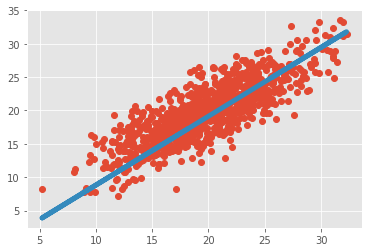

In [4]:
#绘图验证函数2
mean = [20, 20]
cov = [[5, 0], [25, 25]]
x, y = np.random.multivariate_normal(mean, cov, 1000).T
test_data = np.array((x,y)).T
param, inliers = ransac(test_data)
params = param[np.where(inliers==inliers.max())]
x_fit = x
y_fit = params[0][0] * x + params[0][1]
print(x.shape, y.shape,params)
plt.plot(x, y,'o',zorder=1)
plt.plot(x_fit, y_fit, linewidth = '5')